In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

In [2]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-22 16:08:24.376059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load data

## Weather regimes

In [3]:
week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week7_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week7_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week8_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week8_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week9_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week9_wr_v3.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr,week7_wr,week8_wr,week9_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6','week7','week8','week9']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v3.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

## Input Variables

In [4]:
variables = ['z500']
name_var = ['z500']
units = ['m2/s2']


In [5]:
dic_vars = {}
for var_short, variable,unit in zip(name_var,variables,units):
# for var_short, variable,unit in zip(['sst'],['sst'],['K']):
    path_w_anoms = '/glade/work/jhayron/Weather_Regimes/weekly_anomalies/'
    week1_anoms = xr.open_dataset(f'{path_w_anoms}week1_{variable}_anoms_v3.nc')
    # week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    if variable=='z500':
        week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)
    # week1_anoms = week1_anoms.sel(time=df_wr.index)
    week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    dic_vars[variable] = week1_anoms
    
    ##########PLOT#####################
#     fig = plt.figure(figsize=(9,7))
#     ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))
    
#     #     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     #     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
    
#     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     # print(vmax,vmin)
#     cs = plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,\
#         week1_anoms[f'{var_short}_anomalies'].values[0],cmap='seismic',
#         transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
#     ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
#     ax.margins(x=0, y=0)

#     # ax.set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())
#     if variable!='st':
#         plt.title(variable.upper().replace('_','-'))
#     else:
#         plt.title(variable.upper().replace('_','-').replace('ST','TS'))
#     if 'region' in variable:
#         cbar_ax = fig.add_axes([0.25, 0.19, 0.5, 0.0175])
#     else:
#         cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.0175])
#     # ticks_1 = [-80, -40, 0, 40, 80]
#     cbar = fig.colorbar(cs, cax=cbar_ax,
#                         orientation='horizontal', extend='both')
#     cbar.ax.tick_params(labelsize=14)
#     cbar.set_label(unit, fontsize=14)
#     plt.savefig(f'/glade/u/home/jhayron/WeatherRegimes/Figures/MapsVariables/{variable}_anomalies_v2.png',bbox_inches='tight')
#     plt.close('all')

# Build models

In [6]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization,SpatialDropout2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

# Predict

In [8]:
def create_model(ks,ps,type_pooling,stc,stp,do,bn,md,nfilters,activation):
    num_classes = 4
    
    if activation == 'LeakyReLU':
        activation_conv= LeakyReLU()
    elif activation == 'ReLU':
        activation_conv= ReLU()
        
    padding_type = 'same'
    model = Sequential()
    
    model.add(Conv2D(nfilters, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding=padding_type,strides=stc))
    
    if type_pooling == 'Max':
        model.add(MaxPooling2D((ps, ps),padding=padding_type,strides=stp))
    elif type_pooling == 'Average':
        model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=stp))
        
    model.add(Dropout(do))
    if bn==True:
        model.add(BatchNormalization())
        
    model.add(Conv2D(nfilters*2, (ks, ks), activation=activation_conv,padding=padding_type,strides=stc))
    
    if type_pooling == 'Max':
        model.add(MaxPooling2D((ps, ps),padding=padding_type,strides=stp))
    elif type_pooling == 'Average':
        model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=stp))
        
    model.add(SpatialDropout2D(do))
    if bn==True:
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(num_classes*md*md, activation=activation_conv))
    model.add(Dense(num_classes*md, activation=activation_conv))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model

In [9]:
suffix = ['noweights','weights1','weights2']

for inamefolder,name_folder in enumerate(['weights_variables_v7',
                   'weights_variables_v7_weights_1',
                   'weights_variables_v7_weights_2']):
    print(inamefolder)

    path_models = f'/glade/work/jhayron/Weather_Regimes/models/CNN/{name_folder}/'

    dic_results = {}
    dic_probability = {}

    for var_short, variable in zip(name_var,variables):
        print('********************************************************************************************')
        print(variable)
        print('********************************************************************************************')
        loss_weeks_model = []
        loss_weeks_persistence = []
        acc_weeks_model = []
        acc_weeks_persistence = []

        df_results_persistence = pd.DataFrame()
        df_results = pd.DataFrame()
        dic_probability2 = {}
        for week in ['week1','week2','week3']:
            print(week)
            #### ORGANIZE DATA ####
            week_output_wr = df_wr_2[week].values.astype(int)
            # Make Y categorical
            serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

            week1_anoms = copy.deepcopy(dic_vars[variable])

            # # Scale by min-max
            where = np.where(pd.to_datetime(week1_anoms.time.values).year<=2010)[0]
            Min = week1_anoms.isel(time=where)[f'{var_short}_anomalies'].min(dim='time')
            Max = week1_anoms.isel(time=where)[f'{var_short}_anomalies'].max(dim='time')
            scaled_x = (week1_anoms[f'{var_short}_anomalies']) / (Max - Min)

            indices = np.arange(len(serie_wr_categorical))
            #Reshape X
            scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)
            scaled_x[np.isfinite(scaled_x)==False]=0

            indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
            indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
            indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

            X_test = scaled_x[indices_test]
            y_test = serie_wr_categorical[indices_test]

            X_train = scaled_x[indices_train]
            y_train = serie_wr_categorical[indices_train]

            X_val = scaled_x[indices_val]
            y_val = serie_wr_categorical[indices_val]

            wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
            serie_wr_persistence_categorical = to_categorical(wr_persistence)

            df_results_persistence[week] = wr_persistence


            ## TRAIN
            results_directory = f'/glade/work/jhayron/Weather_Regimes/models/CNN/results_optuna/{week}/'
            study_optuna = joblib.load(results_directory + 'optuna_study_v2.pkl')
            dict_params = study_optuna.best_params
            print(dict_params)
            keras.backend.clear_session()
            model = create_model(dict_params['ks'],
                                 dict_params['ps'],
                                 dict_params['type_pooling'],
                                 dict_params['stc'],
                                 dict_params['stp'],
                                 dict_params['do'],
                                 dict_params['bn'],
                                 dict_params['md'],
                                 dict_params['nfilters'],
                                 dict_params['activation'],
                                )

            earlystop = EarlyStopping(monitor='val_loss', patience=5)
            try:
                os.mkdir(f'{path_models}{variable}')
            except: pass
            filepath = f'{path_models}{variable}/model_{week}_v7.h5'

            #### EVAL ####

            model.load_weights(filepath)
            results = model.predict(X_test)
            prob_temp = results#.max(axis=1)
            result_temp = results.argmax(axis=1)

            df_results[week] = result_temp
            dic_probability2[week] = prob_temp
            df_results_persistence[week] = wr_persistence
        df_results.index = df_wr_2.iloc[indices_test].index
        # df_probability.index = df_wr_2.iloc[indices_test].index
        df_results_persistence.index = df_wr_2.iloc[indices_test].index
        dic_results[variable] = df_results
        dic_probability[variable] = dic_probability2
        
        np.save(f'/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_results_{suffix[inamefolder]}.npy',dic_results)
        np.save(f'/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_probability_{suffix[inamefolder]}.npy',dic_probability)
        df_results_persistence.to_csv(f'/glade/work/jhayron/Weather_Regimes/models_results/CNN_v7/dic_probability_persistence_{suffix[inamefolder]}.csv')


0
********************************************************************************************
z500
********************************************************************************************
week1
{'ks': 7, 'ps': 2, 'type_pooling': 'Average', 'stc': 2, 'stp': 2, 'do': 0.5, 'bn': False, 'md': 4, 'nfilters': 32, 'activation': 'ReLU', 'bs': 32}


2023-01-22 16:15:48.213519: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-22 16:15:48.214746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-22 16:15:48.242059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-22 16:15:48.242105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-22 16:15:48.278356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-22 16:15:48.278408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

week2
{'activation': 'LeakyReLU', 'bn': False, 'bs': 32, 'do': 0.4, 'ks': 3, 'md': 8, 'nfilters': 8, 'ps': 6, 'stc': 1, 'stp': 3, 'type_pooling': 'Average'}
week3
{'activation': 'LeakyReLU', 'bn': False, 'bs': 16, 'do': 0.4, 'ks': 11, 'md': 4, 'nfilters': 16, 'ps': 6, 'stc': 2, 'stp': 2, 'type_pooling': 'Average'}
1
********************************************************************************************
z500
********************************************************************************************
week1
{'ks': 7, 'ps': 2, 'type_pooling': 'Average', 'stc': 2, 'stp': 2, 'do': 0.5, 'bn': False, 'md': 4, 'nfilters': 32, 'activation': 'ReLU', 'bs': 32}
week2
{'activation': 'LeakyReLU', 'bn': False, 'bs': 32, 'do': 0.4, 'ks': 3, 'md': 8, 'nfilters': 8, 'ps': 6, 'stc': 1, 'stp': 3, 'type_pooling': 'Average'}
week3
{'activation': 'LeakyReLU', 'bn': False, 'bs': 16, 'do': 0.4, 'ks': 11, 'md': 4, 'nfilters': 16, 'ps': 6, 'stc': 2, 'stp': 2, 'type_pooling': 'Average'}
2
********************

# Plot model

In [12]:
# import visualkeras
# # visualkeras.layered_view(model, legend=True) # without custom font
# from PIL import ImageFont
# # font = ImageFont.truetype("arial.ttf", 12)
# visualkeras.layered_view(model, legend=True,draw_volume=False) # selected font

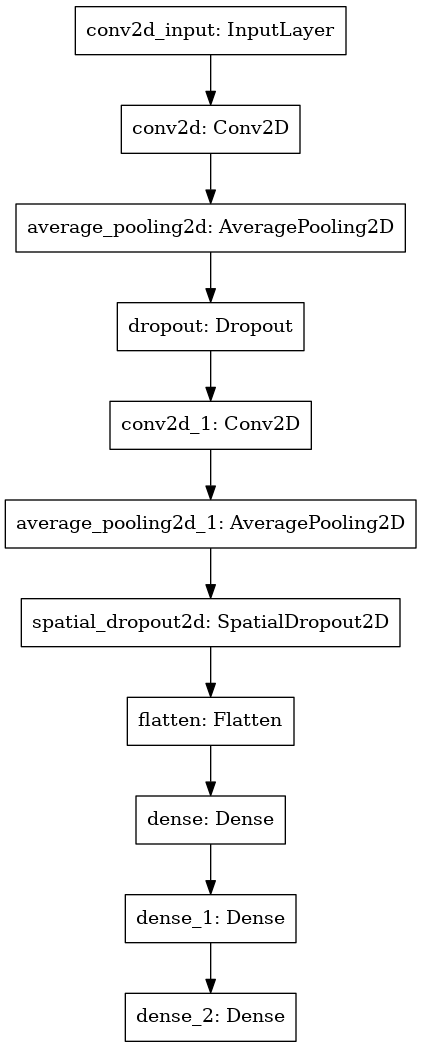

In [13]:
from keras.utils.vis_utils import plot_model
path_figs = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plot_model(model, to_file=f'{path_figs}CNNShape_v7.png', show_shapes=False, show_layer_names=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 180, 16)       1952      
_________________________________________________________________
average_pooling2d (AveragePo (None, 30, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 45, 32)        61984     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 23, 32)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 8, 23, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5888)              0

In [15]:
X_test.shape

(555, 120, 360, 1)